<a href="https://colab.research.google.com/github/yashikart/Blood-Group-Detection-Using-Fingerprints/blob/main/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fingerprint Analysis Pipeline

## 1. Pattern Type (fingerprint_class)
**Function Used:** `classify_fingerprint(image_path)`

**Method:**  
- The image is preprocessed (`preprocess_image`) to match the model input format.  
- A deep learning model (`mobilenetv2.h5`) predicts the class (Arch, Loop, or Whorl).  
- The class with the highest probability is selected using `np.argmax(predictions)`.

---

## 2. Total Minutiae Points
**Formula:**  
$$ \text{Total Minutiae} = \text{len}(\text{minutiae_endings}) + \text{len}(\text{minutiae_bifurcations}) $$

**Functions Used:**  
- `thin_fingerprint(binary_image)`: Skeletonization of the fingerprint.  
- `extract_minutiae(skeleton_image)`: Identifies minutiae points.  

**Method:**  
- The binary fingerprint image is skeletonized using `skeletonize()`, reducing ridges to a one-pixel width.  
- Minutiae (endings & bifurcations) are detected by analyzing pixel transitions in an 8-neighbor window.

**Formula for Minutiae Detection (Crossing Number Method):**  

$$ CN = \frac{1}{2} \sum_{i=1}^{8} | P(i) - P(i+1) | $$  

Where \( P(i) \) are the pixel values around a central pixel.  
- If \( CN = 1 \), it's an **ending**.  
- If \( CN = 3 \), it's a **bifurcation**.

---

## 3. Ridge Count
**Function Used:** `calculate_ridge_count(binary_image)`

**Method:**  
- Uses Sobel edge detection (`sobel(binary_image)`) to detect ridge edges.  
- Counts nonzero edges in the Sobel output.

**Formula for Ridge Count:**  

$$ Ridge\_Count = \sum_{x,y} I(x,y) > T $$  

Where \( I(x,y) \) is the Sobel-filtered image, and \( T \) is an edge threshold.

---

## 4. Ridge Density
**Function Used:** `calculate_ridge_density(binary_image)`

**Method:**  
- Calculates the ratio of ridge pixels to total image pixels.

**Formula:**  

$$ Ridge\_Density = \frac{\text{Number of Ridge Pixels}}{\text{Total Pixels}} $$

---

## 5. Core-Delta Distance
**Function Used:** `extract_core_delta_distance(binary_image)`

**Method:**  
- Contours are detected using `cv2.findContours()`.  
- The first two major contours (representing core and delta points) are extracted.  
- The Euclidean distance is computed between the core and delta points.

**Formula (Euclidean Distance):**  

$$ d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2} $$  

Where \( (x_1, y_1) \) is the core and \( (x_2, y_2) \) is the delta.

---

## 6. Ending & Bifurcation Coordinates
**Function Used:** `extract_minutiae(skeleton_image)`

**Method:**  
- Extracts \( (x, y) \) coordinates of detected minutiae points (endings and bifurcations).  
- These are stored as lists for each image.

---




In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# Define constants
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 100

# Dataset paths
data_dir = "/content/drive/MyDrive/Blood Group Detection/Pattern Classification/Dataset"
train_dir = os.path.join(data_dir, 'Train')
val_dir = os.path.join(data_dir, 'Validation')

# Verify class labels
class_names = sorted(os.listdir(train_dir))
print(f"Class labels: {class_names}")

# Data Augmentation & Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.1
)

# Load Dataset
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load Pre-trained Model (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base model layers

# Custom Classifier Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(train_data, validation_data=val_data, epochs=EPOCHS)


Class labels: ['Arch', 'Loop', 'Whorl']
Found 266 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 113s 6s/step - accuracy: 0.3555 - loss: 1.2054 - val_accuracy: 0.4778 - val_loss: 0.8934
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5313 - loss: 0.8947 - val_accuracy: 0.6444 - val_loss: 0.7846
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6110 - loss: 0.8405 - val_accuracy: 0.6889 - val_loss: 0.6585
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6291 - loss: 0.8593 - val_accuracy: 0.7111 - val_loss: 0.6553
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6976 - loss: 0.6654 - val_accuracy: 0.8000 - val_loss: 0.6074
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6929 - loss: 0.6703 - val_accuracy: 0.7889 - val_loss: 0.5836
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6878 - loss: 0.7170 - val_accuracy: 0.7444 - val_loss: 0.5669
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7667 - loss: 0.6263 - val_accuracy: 0.7778 - 

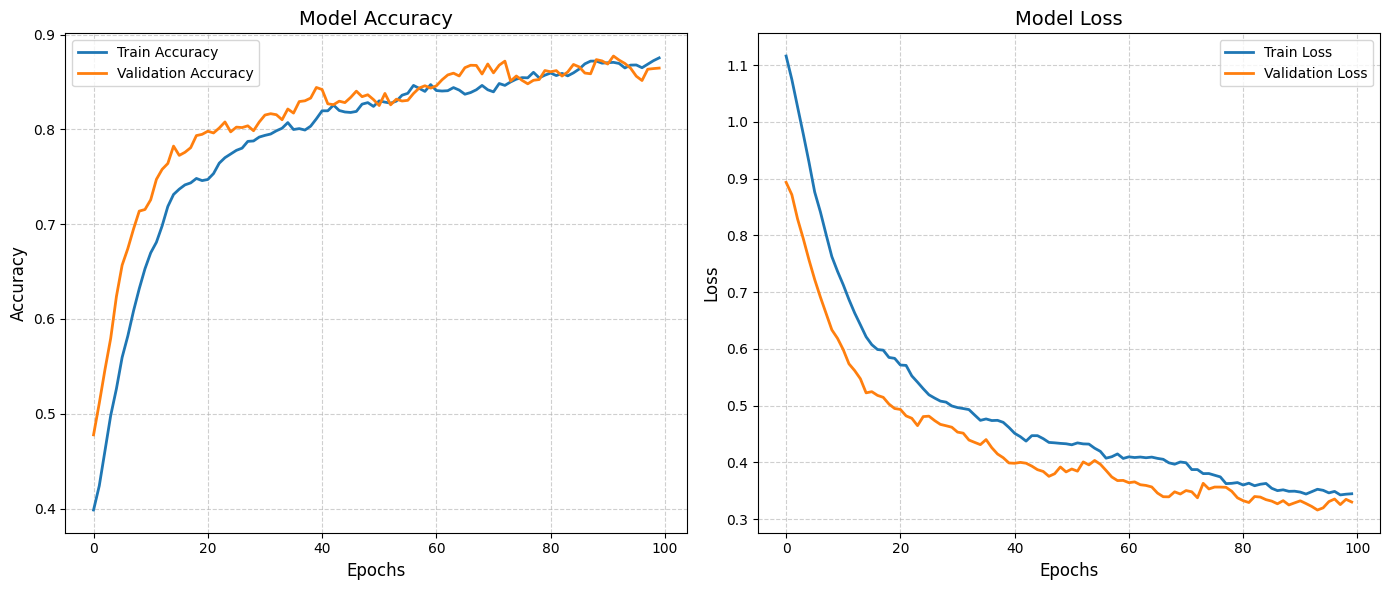

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.8):
    """Apply exponential moving average to smooth the curve"""
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def plot_history(history):
    plt.figure(figsize=(14, 6))

    # Smoothed Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(smooth_curve(history.history['accuracy']), label='Train Accuracy', linewidth=2)
    plt.plot(smooth_curve(history.history['val_accuracy']), label='Validation Accuracy', linewidth=2)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.title('Model Accuracy', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Smoothed Loss
    plt.subplot(1, 2, 2)
    plt.plot(smooth_curve(history.history['loss']), label='Train Loss', linewidth=2)
    plt.plot(smooth_curve(history.history['val_loss']), label='Validation Loss', linewidth=2)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.title('Model Loss', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_history(history)


In [4]:
MODEL_PATH = "/content/drive/MyDrive/Blood Group Detection/mobilenetv2.h5"
model.save(MODEL_PATH)
print(f"Model saved as {MODEL_PATH}")

Model saved as /content/drive/MyDrive/Blood Group Detection/mobilenetv2.h5


In [5]:
# Evaluate Model
y_true, y_pred = [], []
for images, labels in val_data:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if len(y_true) >= val_data.samples:
        break

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Model Accuracy: 84.44%


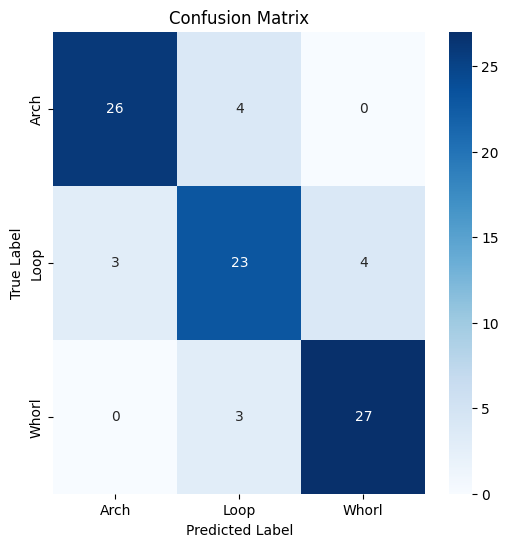

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

        Arch       0.90      0.87      0.88        30
        Loop       0.77      0.77      0.77        30
       Whorl       0.87      0.90      0.89        30

    accuracy                           0.84        90
   macro avg       0.84      0.84      0.84        90
weighted avg       0.84      0.84      0.84        90



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: Loop with Confidence: 88.58%


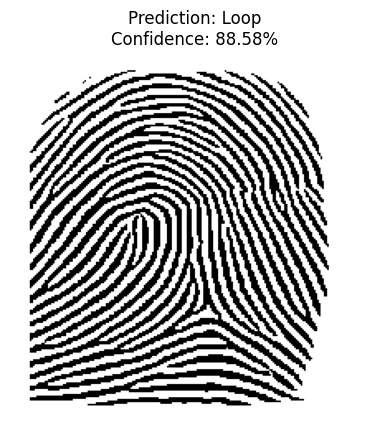

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras.preprocessing import image

# Define paths
MODEL_PATH = "/content/drive/MyDrive/Blood Group Detection/mobilenetv2.h5"
IMAGE_PATH = "/content/drive/MyDrive/Blood Group Detection/enhanced5.BMP"

# Check if model file exists before loading
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

# Load the trained model
model = keras.models.load_model(MODEL_PATH)

# Define image size (should match model training input)
IMG_SIZE = 224  # MobileNetV2 default input size

# Define class names (ensure they match model output classes)
class_names = ["Arch", "Loop", "Whorl"]  # Modify if needed

# Function to preprocess and predict an image
def predict_image(img_path, model, class_names):
    try:
        # Check if image file exists
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(img) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input

        # Make prediction
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction)  # Get class index
        confidence = np.max(prediction)  # Get confidence score

        # Display result
        print(f"Predicted Class: {class_names[predicted_class]} with Confidence: {confidence * 100:.2f}%")

        # Show the image with prediction
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Prediction: {class_names[predicted_class]}\nConfidence: {confidence * 100:.2f}%")
        plt.show()

    except Exception as e:
        print(f"Error during prediction: {e}")

# Predict the image
predict_image(IMAGE_PATH, model, class_names)


In [12]:
import cv2
import numpy as np
import os
import pandas as pd
import time
from skimage.morphology import skeletonize
from skimage.filters import sobel
from scipy.spatial.distance import euclidean
from tensorflow.keras.models import load_model

# Paths
image_folder = "/content/drive/MyDrive/Blood Group Detection/Gabor filter/"
output_excel = "/content/drive/MyDrive/Blood Group Detection/fingerprint_features_data.xlsx"
model_path = "/content/drive/MyDrive/Blood Group Detection/mobilenetv2.h5"

# Load trained model
model = load_model(model_path)

def preprocess_image(image_path):
    """Preprocess the image for model prediction."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (224, 224))  # Resize for the model
    image = image.astype("float32") / 255.0  # Normalize
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.repeat(image, 3, axis=-1)  # Convert grayscale to 3-channel
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def classify_fingerprint(image_path):
    """Predict the fingerprint pattern class using the model."""
    processed_image = preprocess_image(image_path)
    predictions = model.predict(processed_image)
    class_labels = ["Arch", "Loop", "Whorl"]
    return class_labels[np.argmax(predictions)]  # Get predicted class

def enhance_fingerprint(image_path):
    """Enhance fingerprint using Gaussian Blur and Adaptive Thresholding."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    return image, binary

def thin_fingerprint(binary_image):
    """Apply skeletonization to thin the fingerprint."""
    skeleton = skeletonize(binary_image > 0)
    return (skeleton * 255).astype(np.uint8)

def extract_minutiae(skeleton_image):
    """Extract minutiae points (endings and bifurcations)."""
    minutiae_endings = []
    minutiae_bifurcations = []

    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, 1),
                 (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]

    for i in range(1, skeleton_image.shape[0] - 1):
        for j in range(1, skeleton_image.shape[1] - 1):
            if skeleton_image[i, j] == 255:
                block = [skeleton_image[i + dx, j + dy] for dx, dy in neighbors]
                transitions = sum((block[k] == 0 and block[k + 1] == 255) for k in range(8))

                if transitions == 1:
                    minutiae_endings.append((j, i))
                elif transitions == 3:
                    minutiae_bifurcations.append((j, i))

    return minutiae_endings, minutiae_bifurcations

def calculate_ridge_count(binary_image):
    """Compute ridge count using Sobel edge detection."""
    edge_image = sobel(binary_image)
    return np.count_nonzero(edge_image > 0.1)

def calculate_ridge_density(binary_image):
    """Calculate ridge density as a ratio of ridge pixels to total pixels."""
    total_pixels = binary_image.size
    ridge_pixels = np.count_nonzero(binary_image)
    return ridge_pixels / total_pixels

def extract_core_delta_distance(binary_image):
    """Estimate core-delta distance using contour detection."""
    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) < 2:
        return None
    core = tuple(contours[0][0][0])
    delta = tuple(contours[1][0][0])
    return euclidean(core, delta)

def process_all_fingerprints(image_folder, output_excel):
    """Process all fingerprint images in the folder and save data to Excel."""
    data = []
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith((".bmp", ".jpg", ".jpeg", ".png", ".tif"))]

    if not image_files:
        print("⚠️ No valid images found in the folder!")
        return

    start_time = time.time()  # Start timing

    for filename in image_files:
        image_path = os.path.join(image_folder, filename)

        try:
            original, binary = enhance_fingerprint(image_path)
            thinned = thin_fingerprint(binary)
            minutiae_endings, minutiae_bifurcations = extract_minutiae(thinned)
            ridge_count = calculate_ridge_count(binary)
            ridge_density = calculate_ridge_density(binary)
            core_delta_distance = extract_core_delta_distance(binary)
            fingerprint_class = classify_fingerprint(image_path)  # Get pattern type

            # Prepare minutiae coordinates for Excel
            endings_x, endings_y = zip(*minutiae_endings) if minutiae_endings else ([], [])
            bifurcations_x, bifurcations_y = zip(*minutiae_bifurcations) if minutiae_bifurcations else ([], [])

            # Store data in list
            data.append({
                "Image Name": filename,
                "Pattern Type": fingerprint_class,
                "Total Minutiae Points": len(minutiae_endings) + len(minutiae_bifurcations),
                "Ridge Count": ridge_count,
                "Ridge Density": ridge_density,
                "Core-Delta Distance": core_delta_distance,
                "Ending X": list(endings_x),
                "Ending Y": list(endings_y),
                "Bifurcation X": list(bifurcations_x),
                "Bifurcation Y": list(bifurcations_y)
            })

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            pass  # Skip any errors and continue

    # Convert list to DataFrame
    df = pd.DataFrame(data)

    # Save to Excel
    df.to_excel(output_excel, sheet_name="Fingerprint Analysis", index=False)

    end_time = time.time()  # End timing
    print(f"Processing Completed in {end_time - start_time:.2f} seconds!")

# Run the function
process_all_fingerprints(image_folder, output_excel)


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144